

[참고 코드]
https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py


In [1]:
!mkdir results

In [2]:
!ls

results  sample_data


In [3]:
!cd results
!ls

results  sample_data


In [4]:
!cat results

cat: results: Is a directory


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)

print('현재 device :', device)

현재 device : cuda


# 1. Model(MLP)

In [8]:
class MLP(nn.Module):
    
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, batch_normal, dropout_p, weight_init):
        super(MLP,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer  # n_layer = hid_dim(1) + ... + hid_dim(n-1) + out_dim(n)
        self.act = act
        self.batch_normal = batch_normal
        self.dropout = dropout_p
        
        #===Create sequence space===#
        self.linears = nn.ModuleList()
        self.batch_normals = nn.ModuleList()
        
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        for idx in range(n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            # 레이어 마다 batch_normalization 시행 예정-> [linear - BN - activation] 반복
            if self.batch_normal == True:
                self.batch_normals.append(nn.BatchNorm1d(hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        #===Create Activation Function===#
        if self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act = nn.Tanh()
        elif self.act == 'leaky_relu':
            self.act = nn.LeakyReLU()
        else:
            raise ValueError("no valid activation function selected(sigmoid, relu, leaky_relu, tanh)")
            
        #===Create Regularization layer===#
        # dropout
        self.dropout = nn.Dropout(self.dropout)
        # weight_initialization
        if weight_init == 'xavier':
            self.xavier_init()
        elif weight_init == 'he':
            self.he_init()
        else:
            raise ValueError("no valid weight_initializer selected(xavier, he)")
            
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
    
    def he_init(self):
        for linear in self.linears:
            torch.nn.init.kaiming_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
        
    def forward(self,x):
        out = self.act(self.fc1(x))
        
                                        #===hidden layer===#
        # 레이어 마다 batch_normalization 시행 예정-> [weight_init - linear - BN - activation - dropout] 반복
        # batch_norm, dropout 은 model.train()에서만 ON
        # batch_norm, dropout 은 hidden layer에서만 적용해야 함!
        for idx in range(len(self.linears)):
            out = self.linears[idx](out)
            if self.batch_normals:
                out = self.batch_normals[idx](out)
            out = self.act(out)
            out = self.dropout(out)
                                        #===hidden layer===#
        
        out = self.fc2(out)
        return out
  

In [9]:
# __init__(self, in_dim, out_dim, hid_dim, n_layer, act, batch_normal, dropout_p, weight_init):

# model = MLP(3072,10,100,4,'leaky_relu',batch_normal=True,dropout_p=0.1,weight_init='he')

# 1. Model(CNN)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1,stride=1),
            nn.Conv2d(64,256,kernel_size=5,padding=2,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(65536,10)

    def forward(self,x):
        out = self.conv_layer1(x)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        return out



In [11]:
# def dimension_check():
#     model = CNN()
#     x = torch.rand(2,3,32,32)
#     out = model(x)
#     print(out.shape)


In [12]:
# dimension_check()

# 1. Model(CNN_VGG)

In [13]:
# M : maxpooling 단계, int : out channel 숫자 
# M 은 모두 5개 ==>> 전체 width = height = 32 니까, 5번의 maxpooling 통해 receptive field = 1 (32/2/2/2/2/2 = 1) 로 만들어, receptive field = 전체 image로 만들겠다.
# 최종적으로 뽑아낸 복잡한 feature들로 receptive field를 전체 이미지 범위로 놓고, 모든 이미지에 이 feature map을 만들어내겠다. 는 것.
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [14]:
# out_dim, args.batch_normal, args.weight_init = 'he', args.act

class CNN_VGG(nn.Module):
    def __init__(self, model_code, in_channels, batch_normal, out_dim, weight_init, act, dropout_p):
        super(CNN_VGG,self).__init__()

        #===Create Activation Function===#
        if act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'relu':
            self.act = nn.ReLU()
        elif act == 'tanh':
            self.act = nn.Tanh()
        elif act == 'leaky_relu':
            self.act = nn.LeakyReLU()
        else:
            raise ValueError("no valid activation function selected(sigmoid, relu, leaky_relu, tanh)")

        #===Convolutional layer sequence===#
        self.layers = self._make_layers(model_code, in_channels, batch_normal)

        #===Fully-connected layer : [ (weight_init - linear - activation - dropout) - output linear ]===#
        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Sequential(nn.Linear(512*1*1, 256),
                                        self.act,
                                        self.dropout,
                                        nn.Linear(256, out_dim))
        # 마지막 output layer에는 activation function 하지 않는다. softmax가 loss_function에 포함되어있기 때문에.

        #===weight_initialization===#
        if weight_init == 'xavier':
            self.xavier_init()
        elif weight_init == 'he':
            self.he_init()
        else:
            raise ValueError("no valid weight_initializer selected(xavier, he)")
        

    # _ : private method, class 안에서만 활용되는 함수. global scope가 아님.
    def _make_layers(self, model_code, in_channels, batch_normal):

        # (conv + relu) + maxpool
        layers = []
        
        for x in cfg[model_code]:
            # + maxpool
            if x == 'M':
                layers.append(nn.MaxPool2d(2))

            # # + conv + BN + relu
            # else: 
            #     # conv
            #     layers.append(nn.Conv2d(in_channels = in_channels, out_channels = x, kernel_size=3, padding=1, stride=1))
            #     # BN
            #     if batch_normal == True:
            #         layers.append(nn.BatchNorm2d(x))
            #     # relu
            #     layers.append(self.act)
            #     in_channels=x

            # + conv + relu + BN
            else: 
                # conv
                layers.append(nn.Conv2d(in_channels = in_channels, out_channels = x, kernel_size=3, padding=1, stride=1))
                # relu
                layers.append(self.act) 
                # BN
                if batch_normal == True:
                    layers.append(nn.BatchNorm2d(x))
                in_channels=x

        # *layers : layers안에 들어있는 object들을 가변길이로 Sequential method에 argument로 넣기 위해 *붙임
        return nn.Sequential(*layers)

    def forward(self,x):
        out = self.layers(x)
        out = out.view(out.size(0),-1)  # flatten
        out = self.classifier(out)
        return out

    def xavier_init(self):
        for linear in self.classifier:
            if linear != self.act and linear != self.dropout:
                nn.init.xavier_normal_(linear.weight)
                linear.bias.data.fill_(0.01)
    
    def he_init(self):
        for linear in self.classifier:
            if linear != self.act and linear != self.dropout:
                torch.nn.init.kaiming_normal_(linear.weight)
                linear.bias.data.fill_(0.01)


In [15]:
# def dimension_check():
#     model = CNN_VGG('VGG11', in_channels = 3) 
#     x = torch.rand(2,3,32,32)
#     out = model(x)
#     print(out.shape)

In [16]:
# dimension_check()

# 2. Train

In [17]:
def train(model, partition, optimizer, criterion, args):
    # input data preparation
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    model.train()
    
    train_loss = 0.0
    accuracy_batch = 0.0
    total_sample = 0 
    for i, samples in enumerate(trainloader):
        x_data, y_label = samples
        # Convolutional layer input을 위해, MLP와 달리, 4차원 텐서([256,3,32,32])를 그대로 input([batch,channel,width,height])
        # train, validate, test 모두 flatten input 제거
        # x_data = x_data.view(-1,3072) 
        x_data = x_data.to(device)
        y_label = y_label.to(device)
        
        # forward
        output = model(x_data)
        cost = criterion(output, y_label)
        
        # backward
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        train_loss += cost.item()
        _, predicted_label = torch.max(output, dim=1)
        correct = predicted_label == y_label
        accuracy_batch += correct.float().sum().item()
        
        total_sample += y_label.size(0)
    
    
    # batch 당 평균 loss( len(trainloader) == batch 갯수 )
    train_loss_batch = train_loss / len(trainloader) 
    # 모든 sample의 평균 accuracy
    train_acc_batch = (accuracy_batch / total_sample)*100

    # 학습 후의 model을 return해서, 이후 validate 등에 넣어 활용할 예정
    return model, train_loss_batch, train_acc_batch
  

# 2. Validate

In [18]:
def validate(model, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    model.eval()
    
    val_loss = 0.0
    accuracy_batch = 0.0
    total_sample = 0
    with torch.no_grad():
        for samples in valloader:
            x_data, y_label = samples
            # x_data = x_data.view(-1,3072)
            x_data = x_data.to(device)
            y_label = y_label.to(device)
            
            # forward
            output = model(x_data)
            cost = criterion(output, y_label)
            
            # backward (X)
            
            val_loss += cost.item()
            _, predicted_label = torch.max(output, dim=1)
            correct = predicted_label == y_label
            accuracy_batch += correct.float().sum().item()
            
            total_sample += y_label.size(0)
            
        val_loss_batch = val_loss / len(valloader) 
        val_acc_batch = (accuracy_batch / total_sample)*100
    
    return val_loss_batch, val_acc_batch

# 3. Test

In [19]:
def test(model, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    model.eval()
    
    accuracy_batch = 0.0
    total_sample = 0
    with torch.no_grad():
        for samples in testloader:
            x_data, y_label = samples
            # x_data = x_data.view(-1,3072)
            x_data = x_data.to(device)
            y_label = y_label.to(device)
            
            # forward (X)

            # backward (X)
            
            output = model(x_data)
            _, predicted_label = torch.max(output, dim=1)
            correct = predicted_label == y_label
            accuracy_batch += correct.float().sum().item()
            
            total_sample += y_label.size(0)
            
        test_acc_batch = (accuracy_batch / total_sample)*100
    
    return test_acc_batch

# 4. Experiment function

In [20]:
def experiment(partition,args):
    
    # model = MLP(args.in_dim, args.out_dim, args.hid_dim,
    #             args.n_layer, args.act,
    #             args.batch_normal, args.dropout_p, args.weight_init)
    
    # model = CNN()

    model = CNN_VGG(model_code=args.model_code, in_channels=args.in_channels,
                    batch_normal = args.batch_normal, out_dim = args.out_dim, 
                    weight_init = args.weight_init, act = args.act,
                    dropout_p = args.dropout_p)
    
    model.to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    if args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr = args.lr, weight_decay = args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr = args.lr, weight_decay = args.l2)
    elif args.optim == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError("no valid optimizer selected(SGD, RMSprop, ADAM)")
        
    # Create loss, accuracy list for visualization(seaborn)
    # epoch-wise loss, accuracy
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # loop (train / val)
    for epoch in range(args.epoch+1):
        ts = time.time()
        
        model, train_loss_batch, train_acc_batch = train(model, partition, optimizer, criterion, args)
        val_loss_batch, val_acc_batch = validate(model, partition, criterion, args)
        
        te = time.time()
        
        train_losses.append(train_loss_batch)
        val_losses.append(val_loss_batch)
        train_accs.append(train_acc_batch)
        val_accs.append(val_acc_batch)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}.\
              Took {:2.2f} sec'.format(epoch, train_acc_batch, val_acc_batch, train_loss_batch, val_loss_batch, te-ts))
    
    test_acc_batch = test(model, partition, args)
    
    # to keep track of the result of each experiment
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc_batch
    result['val_acc'] = val_acc_batch
    result['test_acc'] = test_acc_batch
    
    # vars(object) : object가 갖는 attribute를 return! (result의 experiment arguments를 return하기 위함
    # vars(object) : object의 attribute를 dictionary 로 return!
    return vars(args), result

# 5. Save and Load

In [21]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name'] 
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    # .updata : dictionary의 append와 같음 (result.update(setting) : result dict + setting dict)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# 6. Experiment

In [22]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp0_Reg"

# ====== Model Capacity ====== #
# args.in_dim = 3072  # MLP 입력용
args.out_dim = 10
# args.hid_dim = 100  # MLP 입력용
args.act = 'relu'
args.model_code = 'VGG13'   # CNN_VGG
args.in_channels = 3    # CNN_VGG

# ====== Regularization ======= #
args.dropout_p = 0.2
args.batch_normal = True
args.l2 = 1e-3
args.weight_init = 'he'

# ====== Optimizer & Training ====== #
args.optim = 'ADAM' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.002
args.epoch = 13

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'model_code'
name_var2 = 'dropout_p'
list_var1 = ['VGG13','VGG19']
list_var2 = [0.5]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', batch_normal=True, dropout_p=0.5, epoch=13, exp_name='exp0_Reg', in_channels=3, l2=0.001, lr=0.002, model_code='VGG13', optim='ADAM', out_dim=10, test_batch_size=1024, train_batch_size=512, weight_init='he')
Epoch 0, Acc(train/val): 28.03/39.17, Loss(train/val) 2.10/1.60.              Took 13.11 sec
Epoch 1, Acc(train/val): 46.72/48.29, Loss(train/val) 1.45/1.43.              Took 12.93 sec
Epoch 2, Acc(train/val): 58.05/61.60, Loss(train/val) 1.20/1.11.              Took 12.80 sec
Epoch 3, Acc(train/val): 65.44/66.91, Loss(train/val) 1.00/0.94.              Took 12.87 sec
Epoch 4, Acc(train/val): 71.10/69.94, Loss(train/val) 0.85/0.85.              Took 12.89 sec
Epoch 5, Acc(train/val): 76.29/73.08, Loss(train/val) 0.71/0.81.              Took 12.85 sec
Epoch 6, Acc(train/val): 80.00/76.03, Loss(train/val) 0.60/0.71.              Took 12.75 sec
Epoch 7, Acc(train/val): 82.93/78.92, Loss(train/val) 0.52/0.63.              Took 12.85 sec
Epoch 8, Acc(train/val): 8

# 7. Visualize

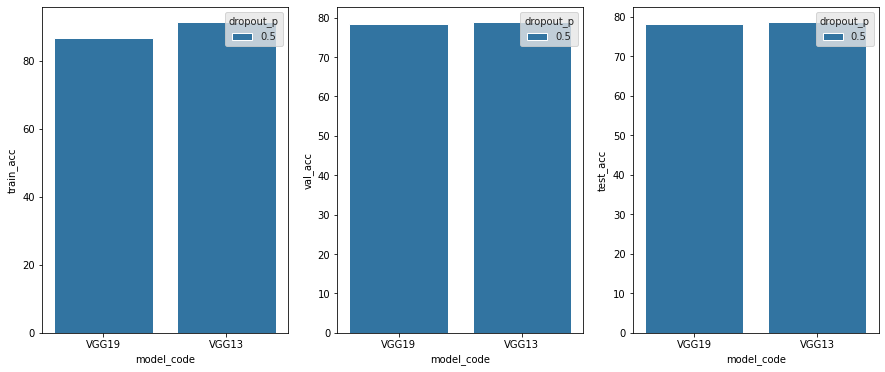

In [23]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp0')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})


sns.barplot(x=name_var1, y='train_acc', hue=name_var2, data=df, ax=ax[0])
sns.barplot(x=name_var1, y='val_acc', hue=name_var2, data=df, ax=ax[1])
sns.barplot(x=name_var1, y='test_acc', hue=name_var2, data=df, ax=ax[2])

# 8. Visualize - Loss

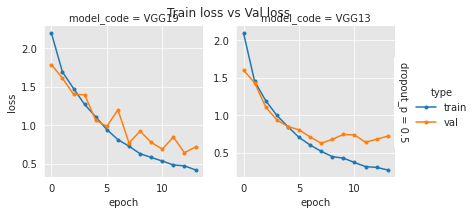

In [24]:
var1 = name_var1
var2 = name_var2

df = load_exp_result('exp0')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

# 9. Visualize - Accuracy

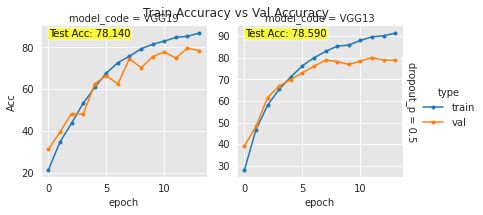

In [25]:
var1 = name_var1
var2 = name_var2

df = load_exp_result('exp')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)